#### Imports

In [174]:
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps
import seaborn as sns

from skimage import morphology
from skimage import io
from skimage.segmentation import slic, mark_boundaries

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,  make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

from scipy.stats import ttest_ind
import statistics

import pickle 

#### Data

In [2]:
file_data = 'data/metadata.csv'
path_image =  'data/images/'
path_mask = 'data/masks/'
path_masked_image = 'data/masked_images'
file_features = 'features/features.csv'

images_id = os.listdir(path_image)
images_id.remove('.gitkeep')

#Read meta-data into a Pandas dataframe
metadata = pd.read_csv(file_data)


### Feature measurements functions

In [3]:
###### ASYMMETRY ######

''' FUNCTION FOR APPLYING MASK TO AN IMAGE '''

def apply_mask(image, mask):
    '''Applies a mask to an image'''

    # Apply mask on the image
    masked_image = np.copy(image)
    masked_image[mask == 0] = 0
    return masked_image

In [4]:
''' ASYMMETRY ''' 

def fix_mask(mask):
    '''Turns a mask into only black(0) or white(255) pixel values. Put the leison in the
     center of the image '''

    #Make it purely black and white
    mask = mask.astype(int)
    mask_pic = Image.fromarray(np.uint8(mask * 255))
    
    #Crop the leison 
    row_index =  np.where(np.sum(mask, axis=1)>0)[0] #all the rows with at least one white element 
    first_row , last_row = row_index[0] , row_index[-1]  #first and last row 
    if (last_row - first_row) %2 != 0:
        last_row += 1 #one extra row to make it even and able to halve it

    col_index =  np.where(np.sum(mask, axis=0)>0)[0] #all the col with at least one white element 
    first_col , last_col = col_index[0] , col_index[-1]  #first and last col 
    if (last_col - first_col) %2 != 0:
        last_col += 1

    cropped_mask = mask_pic.crop((first_col,first_row,last_col,last_row))

    #Add borders
    old_width , old_height = cropped_mask.size 
    fixed_mask = ImageOps.expand(cropped_mask, border = int(old_width/2))

    return fixed_mask

def test_asymmetry(mask):
    '''Takes a mask image, halves it vertically, compares both sides. Returns an index of asymmetry 
    as the proportion of leisure that differs on both sides over the total leison'''

    width,height = mask.size

    #Cut in half
    left = mask.crop((0, 0, int(width/2), height)) #left part of picture (left, top, right, bottom)
    right = mask.crop((int(width/2), 0, width, height)) #right part of picture
    right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

    #Compairing both sides
    asym = np.sum(np.where(np.array(left) != np.array(right), 1, 0))
    total_white = np.sum(np.where(np.array(mask)==255, 1, 0))
   
    return round((asym/total_white), 3)


def get_asymmetry(mask):
    '''Returns the asymmetry for a given leison by rotating the mask image by several angles, measuring 
     the proportion of asymmetry on each, and returning the minimum index. '''
    
    #Leison in the center of the image. Expand black borders to give freedom when rotating image. 
    mask = fix_mask(mask)

    asym = [test_asymmetry(mask.rotate(angle)) for angle in [0,15,30,45,60,75,90]]

    return round(np.min(asym), 3)


In [5]:
def get_average_color(image, mask):
    # Apply mask to image
    masked_image = apply_mask(image, mask)

    r = masked_image[:, :, 0]
    g = masked_image[:, :, 1]
    b = masked_image[:, :, 2]
    
    return [(np.mean(r[r > 0])), (np.mean(g[g > 0])), (np.mean(b[b > 0]))]

In [6]:
def get_color_variability(image, mask, measure='variance'):
    
    # Apply mask on the image
    masked_image = apply_mask(image, mask)
 
    # Find the non-black pixels (i.e., the lesion pixels)
    non_black_pixels = np.where(np.any(masked_image > 0, axis=-1))

    # Extract the color values of the non-black pixels
    r = masked_image[non_black_pixels][:, 0]
    g = masked_image[non_black_pixels][:, 1]
    b = masked_image[non_black_pixels][:, 2]

    # Divide the lesion pixels into segments of similar color
    segments_slic = slic(masked_image[non_black_pixels], n_segments=10, compactness=1, sigma=3, start_label=1)

    # Compute the color variability for each segment that is within the lesion
    segment_color_variability_r = []
    segment_color_variability_g = []
    segment_color_variability_b = []
    for i in range(1, np.max(segments_slic) + 1):
        segment_pixels = np.where(segments_slic == i)[0]
        segment_r = r[segment_pixels]
        segment_g = g[segment_pixels]
        segment_b = b[segment_pixels]

        if measure == 'variance':
            rgb_variability = (np.var(segment_r), np.var(segment_g), np.var(segment_b))
        elif measure == 'standard_deviation':
            rgb_variability = (np.std(segment_r), np.std(segment_g), np.std(segment_b))
        else:
            return None

        segment_color_variability_r.append(rgb_variability[0])
        segment_color_variability_g.append(rgb_variability[1])
        segment_color_variability_b.append(rgb_variability[2])

    return [np.mean(segment_color_variability_r), np.mean(segment_color_variability_g), np.mean(segment_color_variability_b)]

In [7]:
'''COMPACTNESS'''

def area_perimeter(mask): 
    '''Measures the area and perimeter of a mask image'''

    mask = np.where(mask==1, 1, 0)

    #area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    #perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)

    return area, perimeter

 
def get_compactness(mask):
    '''Computes and returns the compactness of a figure'''

    area, perimeter = area_perimeter(mask)

    return round( (perimeter ** 2) /(4* np.pi *area), 4)


### Measuring features ---> csv

In [8]:
def extract_features(mask,image):
    '''Extracts the features of a given mask and image'''

    assymetry = get_asymmetry(mask)
    variability_r, variability_g, variability_b = get_color_variability(image,mask)
    compactness = get_compactness(mask)
    average_r, average_g, average_b = get_average_color(image,mask)

    return assymetry, variability_r, variability_g, variability_b, compactness, average_r, average_g, average_b

In [9]:
def extract_features(image,mask):
    '''Extracts the features of a given mask and image'''
    features = []

    features.append(get_asymmetry(mask))
    # features.append(get_color_variability(image,mask)) split into 3
    features.append((get_color_variability(image,mask)[0]))
    features.append((get_color_variability(image,mask)[1]))
    features.append((get_color_variability(image,mask)[2]))
    features.append(get_compactness(mask))
    # features.append(get_average_color(image,mask)) split into 3
    features.append((get_average_color(image,mask)[0]))
    features.append((get_average_color(image,mask)[1]))
    features.append((get_average_color(image,mask)[2]))

    return features

In [10]:
# Create an empty DataFrame to store the extracted features
df = pd.DataFrame(columns=["Image_ID", "Asymmetry", "Color Variability (R)", "Color Variability (G)", "Color Variability (B)",
                           "Compactness", "Average Color (R)", "Average Color (G)", "Average Color (B)"])

# Iterate over the image files and extract the features
for image_id in images_id:
    # Construct the paths to the image and mask files
    image = plt.imread(path_image + image_id)
    mask = plt.imread(path_mask + 'mask_' + image_id)
    # image_path = os.path.join(image_folder, image_file)
    # mask_path = os.path.join(mask_folder, image_id + "_mask.png")  # Assuming the mask files follow a specific naming convention

    # Run the extract_features function to get the feature values
    features = extract_features(image, mask)
    
    # Create a dictionary with the feature values and image ID
    feature_dict = {"Image_ID": image_id}
    for i, feature_value in enumerate(features):
        feature_dict[df.columns[i + 1]] = feature_value
    
    # Append the feature values to the DataFrame
    df = df.append(feature_dict, ignore_index=True)


C:\Users\flore\AppData\Local\Temp\ipykernel_17144\3675960531.py:39: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare


In [11]:
# Add a column for the diagnosis called 'diagnostic' and take the values from the 'diagnostic' column in the metadata dataframe based on common values in left dataframe from column "image_id" and right dataframe "img_id"
df['Diagnostic'] = df['Image_ID'].map(metadata.set_index('img_id')['diagnostic'])

# Add a column called 'healthy' that is 1 if the diagnostic is in ["NEV", "SEK", "ACK"] and 0 if it is ["MEL", "SCC", "BCC"]
df['Healthy'] = df['Diagnostic'].isin(["NEV", "SEK", "ACK"]).astype(int)


In [13]:
# Save the features dataframe to csv file
df.to_csv('features2.csv', index=False)

### Train classifiers

In [151]:
'''Load and explore data'''
df.head()

,Image_ID,Asymmetry,Color Variability (R),Color Variability (G),Color Variability (B),Compactness,Average Color (R),Average Color (G),Average Color (B),Diagnostic,Healthy
0,PAT_106_159_325.png,0.193,0.001147,0.004648,0.004357,1.2113,0.550330,0.254795,0.232036,BCC,0
1,PAT_107_160_609.png,0.029,0.003076,0.008960,0.011092,0.8237,0.535625,0.478589,0.420036,SEK,1
2,PAT_108_162_660.png,0.051,0.002316,0.006765,0.007490,1.0391,0.565348,0.489717,0.463897,ACK,1
3,PAT_115_1138_870.png,0.192,0.006427,0.003720,0.003231,1.3270,0.480543,0.274811,0.217110,MEL,0
4,PAT_117_179_983.png,0.225,0.003936,0.006734,0.006242,1.6368,0.569064,0.481785,0.505810,BCC,0


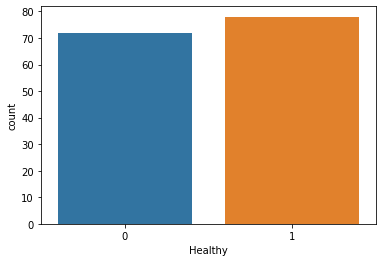

In [152]:
sns.countplot(data=df, x="Healthy");

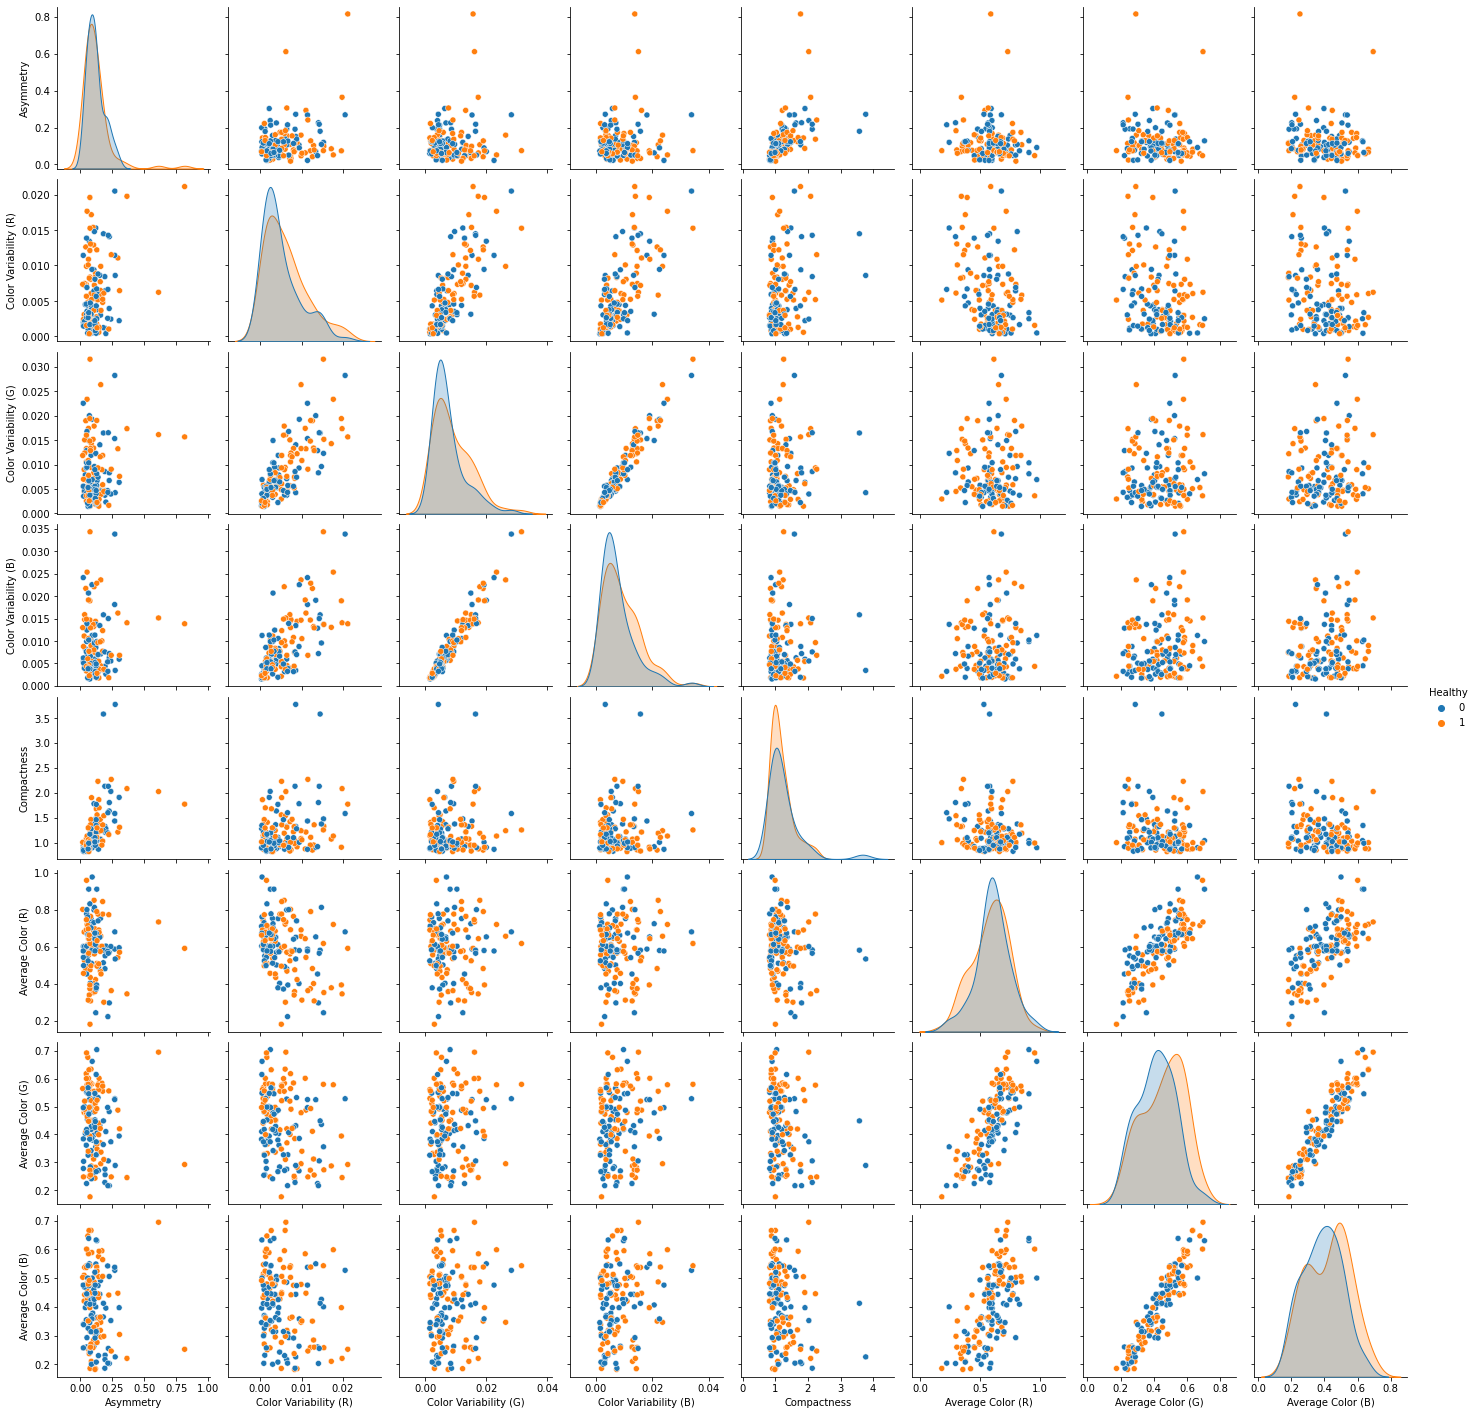

In [153]:
sns.pairplot(data=df, hue="Healthy");

In [154]:
df_clean = df.drop(["Image_ID", "Diagnostic"], axis=1)
df_clean

,Asymmetry,Color Variability (R),Color Variability (G),Color Variability (B),Compactness,Average Color (R),Average Color (G),Average Color (B),Healthy
0,0.193,0.001147,0.004648,0.004357,1.2113,0.550330,0.254795,0.232036,0
1,0.029,0.003076,0.008960,0.011092,0.8237,0.535625,0.478589,0.420036,1
2,0.051,0.002316,0.006765,0.007490,1.0391,0.565348,0.489717,0.463897,1
3,0.192,0.006427,0.003720,0.003231,1.3270,0.480543,0.274811,0.217110,0
4,0.225,0.003936,0.006734,0.006242,1.6368,0.569064,0.481785,0.505810,0
...,...,...,...,...,...,...,...,...,...
145,0.130,0.001211,0.002247,0.002772,1.2976,0.632436,0.522676,0.524337,1
146,0.065,0.003344,0.010338,0.010198,0.9914,0.911278,0.545584,0.637944,0
147,0.241,0.011523,0.009041,0.006787,2.2698,0.362007,0.246900,0.246481,1
148,0.113,0.002221,0.008954,0.011307,1.0163,0.673452,0.546913,0.520429,0


### Train/test data split

In [155]:
# Get the features labels into separate vars
X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1]

# Train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [156]:
print(X_train.shape, y_train.shape)
#print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)

(105, 8) (105,)
(45, 8) (45,)


### Normalisation

In [157]:
feat = ["Asymmetry", "Color Variability (R)", "Color Variability (G)", "Color Variability (B)",
                           "Compactness", "Average Color (R)", "Average Color (G)", "Average Color (B)"]
scaler = StandardScaler().fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train), columns=feat)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feat)


### Train the models

In [167]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_8 = KNeighborsClassifier(n_neighbors=8)
classifiers = { "Knn 1 neighbor": knn_1, "Knn 5 neighbors": knn_5, "Knn 8 neighbors": knn_8}

# Training
for clf in classifiers:
    classifiers[clf].fit(X_train, y_train)

### Evaluate on train data with cross validation

In [168]:
def cross_validate_classifiers(classifiers, X_train, y_train, metrics):
    results = {}

    for clf in classifiers.keys():
        clf_results = {}

        for metric in metrics.keys():
            scores = cross_val_score(classifiers[clf], X_train, y_train, cv=5, scoring=make_scorer(metrics[metric]))
            clf_results[metric] = scores.mean()

        results[clf] = clf_results

    return results


metrics = {"F1": f1_score, "Accuracy score": accuracy_score}

results = cross_validate_classifiers(classifiers, X_train,y_train, metrics)

resultsdf = pd.DataFrame(results)
resultsdf

,Knn 1 neighbor,Knn 5 neighbors,Knn 8 neighbors
F1,0.394167,0.538799,0.422876
Accuracy score,0.419048,0.523810,0.514286


### Selected classifer - Performance evaluation

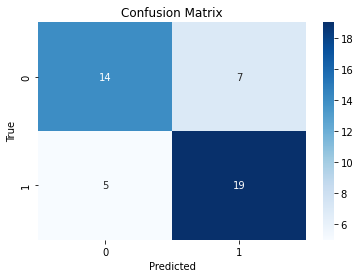

KNN 5 neighbors. F1 score: 0.76. Accuracy score: 0.7333


In [169]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier = classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)
F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)

cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'KNN 5 neighbors. F1 score: {F1}. Accuracy score: {Accuracy}')

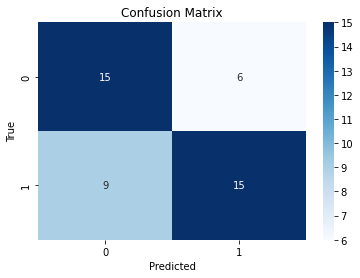

Logistic Regression classifier. F1 score: 0.6667. Accuracy score: 0.6667


In [170]:
# Testing on a parametric model --> Logistic Regression 

classifier = LogisticRegression(random_state=42)
classifier = classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)
F1 = round(f1_score(y_test ,y_pred),4)
Accuracy = round(accuracy_score(y_test ,y_pred),4)

cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Logistic Regression classifier. F1 score: {F1}. Accuracy score: {Accuracy}')


### Saving the selected classifier

In [171]:
classifier = KNeighborsClassifier(n_neighbors=5).fit(X,y)

filename = 'group8_classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

### Evaluate classifier with external data

In [172]:
def classify(img, mask):
    
     #Extract features
     X = extract_features(img, mask)
      
     #Load the trained classifier
     classifier = pickle.load(open('group8_classifier.sav', 'rb'))
    
     #Use it on this example to predict the label AND posterior probability
     pred_label = classifier.predict(X)
     pred_prob = classifier.predict_proba(X)
     
     print('predicted label is ', pred_label)
     print('predicted probability is ', pred_prob)

     return pred_label, pred_prob
 


### Open question

Percentage of not missing values: 64.14 %
Percentage of females: 32.77 %
Percentage of smokers: 8.79 %
Percentage of drinkers: 16.01 %
Percentage of individuals with cancer: 47.39 %


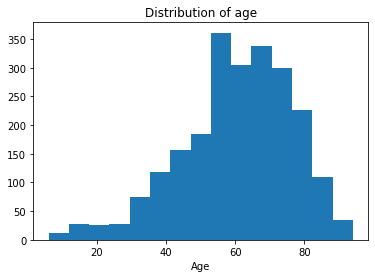

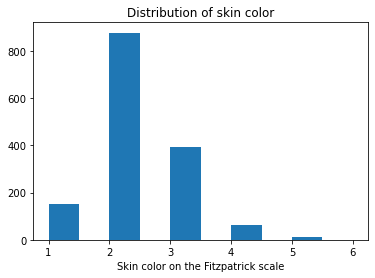

In [173]:
# Number of rows in the dataset
n = metadata.shape[0]

# Rows without any missing values
metadataa = metadata
data = metadata.dropna()
m = data.shape[0]

# Percentage of not missing values
percentage_not_missing = (m / n) * 100
print("Percentage of not missing values:", round(percentage_not_missing,2),"%")

# Percentage of females in cleared data
percentage_female = (metadataa["gender"] == "FEMALE").sum() / n * 100
print("Percentage of females:", round(percentage_female,2),"%")

# Percentage of smokers
percentage_smokers = (metadataa["smoke"] == True).sum() / n * 100
print("Percentage of smokers:", round(percentage_smokers,2),"%")

# Percentage of alcohol drinkers
percentage_drinkers = (metadataa["drink"] == True).sum() / n * 100
print("Percentage of drinkers:", round(percentage_drinkers,2),"%")

# Percentage of individuals with cancer
cancer_types = ["SCC", "MEL", "BCC"]
percentage_cancer = (metadata["diagnostic"].isin(cancer_types)).sum() / n * 100
print("Percentage of individuals with cancer:", round(percentage_cancer,2),"%")

# Distribution of age
plt.hist(metadata["age"], bins=15)
plt.title("Distribution of age")
plt.xlabel("Age")
plt.show()

# Distribution of skin color
plt.hist(metadata["fitspatrick"], bins=10)
plt.title("Distribution of skin color")
plt.xlabel("Skin color on the Fitzpatrick scale")
plt.show()

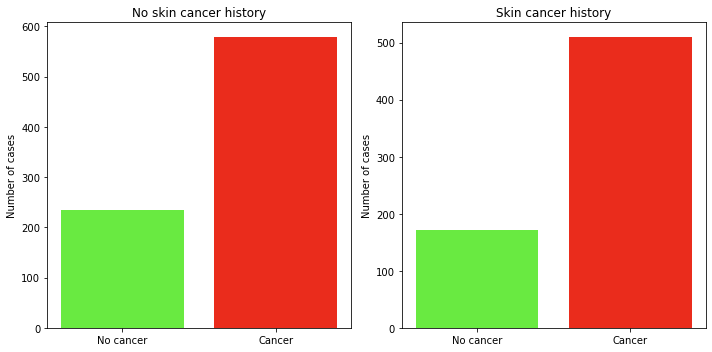

T-test results:
T-statistic: 1.5905625862456043
P-value: 0.0559599488846254
Percentage of people diagnosed with cancer, with skin cancer history: 74.89 %
Percentage of people diagnosed with cancer, without skin cancer history: 71.22 %


In [176]:
# Recode the diagnostic column
metadata["diagnostic"] = metadata["diagnostic"].replace({"ACK": "0", "BCC": "1", "MEL": "1", "NEV": "0", "SCC": "1", "SEK": "0"})

# Subset the data based on skin cancer history
has = metadata[metadata["skin_cancer_history"] == True]
doesnt = metadata[metadata["skin_cancer_history"] == False]

# Calculate the counts for each category in the diagnostic column
no_history_counts = [np.sum(doesnt["diagnostic"] == "0"), np.sum(doesnt["diagnostic"] == "1")]
history_counts = [np.sum(has["diagnostic"] == "0"), np.sum(has["diagnostic"] == "1")]

# Plot bar charts for no skin cancer history and skin cancer history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(["No cancer", "Cancer"], no_history_counts, color=["#69EA41", "#EA2C1C"])
plt.title("No skin cancer history")
plt.ylabel("Number of cases")
plt.subplot(1, 2, 2)
plt.bar(["No cancer", "Cancer"], history_counts, color=["#69EA41", "#EA2C1C"])
plt.title("Skin cancer history")
plt.ylabel("Number of cases")
plt.tight_layout()
plt.show()

# Perform a one-sided t-test to compare the diagnostic "1" counts
t_statistic, p_value = ttest_ind(has["diagnostic"] == "1", doesnt["diagnostic"] == "1", alternative="greater")
print("T-test results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)
print("Percentage of people diagnosed with cancer, with skin cancer history:",round(statistics.mean(has["diagnostic"] == "1")*100,2),"%")
print("Percentage of people diagnosed with cancer, without skin cancer history:",round(statistics.mean(doesnt["diagnostic"] == "1")*100,2),"%")